In [ ]:
!pip install chromadb

In [ ]:
import os
os.environ["CHROMA_DB_API_KEY"] = ""

In [5]:
import os
import chromadb
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import List, Dict, Any

In [6]:
# --- Configuration ---
COLLECTION_NAME = "giki_collection"
# ---------------------

# 1. Setup Client
load_dotenv()
client = chromadb.CloudClient(
    api_key=os.getenv("CHROMA_DB_API_KEY"),
    tenant='3a4f58b1-4505-4361-b7da-9cec61ef8a3f',
    database='gikirag'
)

In [17]:
# 2. Get Collection and Data
try:
    collection = client.get_collection(name=COLLECTION_NAME)

    # Retrieve all data. Since the map data is small, this is safe.
    results = collection.get(
        ids=None, # Retrieve all
        include=['embeddings', 'metadatas']
    )

    # Extract data
    embeddings = np.array(results['embeddings'])
    metadatas = results['metadatas']
    ids = results['ids']

    print(f"Successfully retrieved {embeddings.shape[0]} documents.")
    print(f"Original vector dimensionality: {embeddings.shape[1]}")

except Exception as e:
    print(f"Error accessing ChromaDB or retrieving data: {e}")
    embeddings = None # Set to None to prevent subsequent errors

Successfully retrieved 300 documents.
Original vector dimensionality: 1536


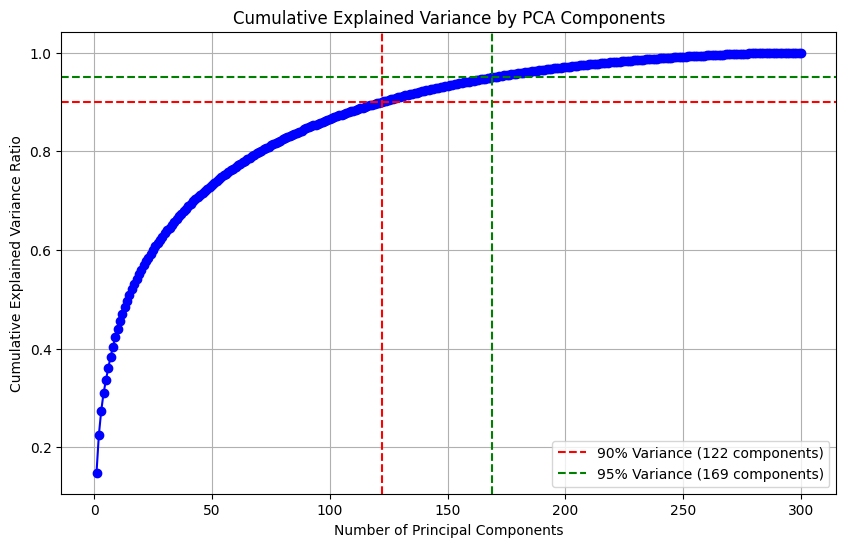


--- PCA Variance Analysis ---
To retain 90% of the variance, you need 122 dimensions.
To retain 95% of the variance, you need 169 dimensions.
If the goal was 256 dimensions (as originally mentioned), the retained variance is: 99.35%


In [12]:
if embeddings is not None and embeddings.shape[0] > 1:
    # 1. Initialize PCA to calculate variance for all components
    pca_full = PCA()
    pca_full.fit(embeddings)

    # Calculate cumulative explained variance
    explained_variance_ratio_cumulative = np.cumsum(pca_full.explained_variance_ratio_)

    # 2. Find the number of components for 90% and 95% variance retention
    n_90 = np.argmax(explained_variance_ratio_cumulative >= 0.90) + 1
    n_95 = np.argmax(explained_variance_ratio_cumulative >= 0.95) + 1

    # 3. Plot the Scree Plot (Cumulative Explained Variance)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o', linestyle='-', color='blue')

    # Add target lines
    plt.axhline(y=0.90, color='r', linestyle='--', label=f'90% Variance ({n_90} components)')
    plt.axvline(x=n_90, color='r', linestyle='--')

    plt.axhline(y=0.95, color='g', linestyle='--', label=f'95% Variance ({n_95} components)')
    plt.axvline(x=n_95, color='g', linestyle='--')

    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"\n--- PCA Variance Analysis ---")
    print(f"To retain 90% of the variance, you need {n_90} dimensions.")
    print(f"To retain 95% of the variance, you need {n_95} dimensions.")
    print(f"If the goal was 256 dimensions (as originally mentioned), the retained variance is: {explained_variance_ratio_cumulative[255]*100:.2f}%")
else:
    print("Skipping PCA Analysis: Data was not successfully loaded.")

/tmp/ipython-input-3687611592.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_categories))


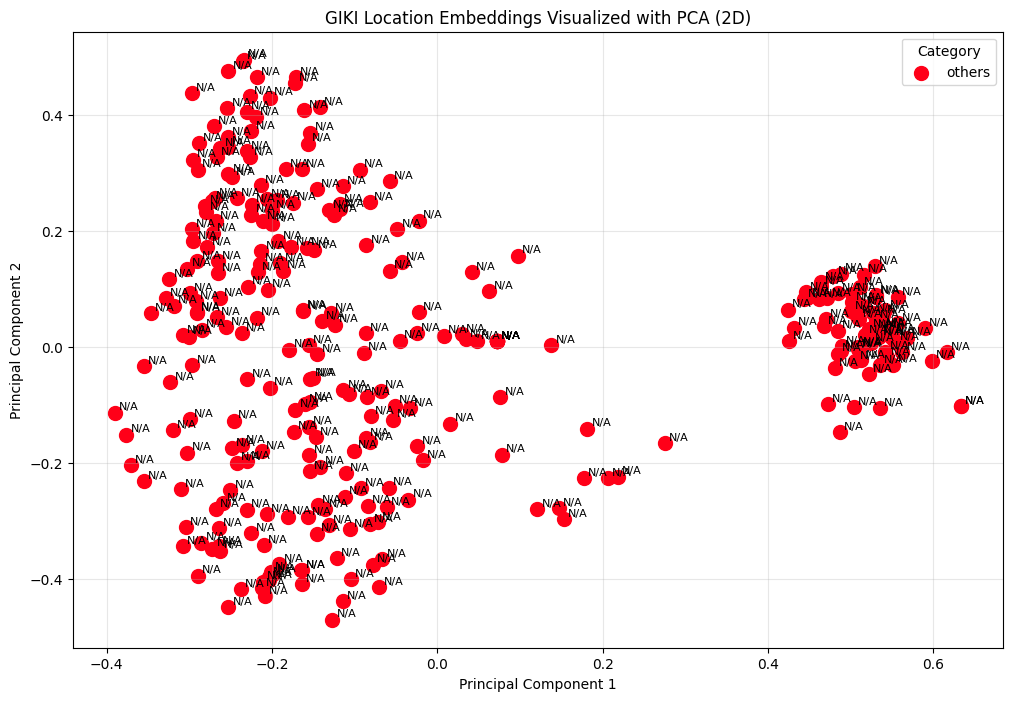


--- 2D Visualization Results ---
The 2D plot shows how different GIKI map locations (like Academic, Residential, Dining) are semantically grouped in the vector space.
If similar categories (e.g., all Academic blocks) cluster together, the original embeddings are effective.


In [13]:
if embeddings is not None and embeddings.shape[0] > 1:
    # 1. PCA to 2 Components for Visualization
    pca_2d = PCA(n_components=2)
    embeddings_2d = pca_2d.fit_transform(embeddings)

    # 2. Prepare Data for Plotting
    # We use a dictionary to assign colors to categories for better visualization
    categories = [m.get('category', 'unknown') for m in metadatas]
    names = [m.get('name', 'N/A') for m in metadatas]
    unique_categories = list(set(categories))

    # Create a distinct color map
    colors = plt.cm.get_cmap('hsv', len(unique_categories))
    category_map = {cat: colors(i) for i, cat in enumerate(unique_categories)}

    # 3. Plot the 2D Reduced Space
    plt.figure(figsize=(12, 8))

    # Plot points and annotate with names
    for i, category in enumerate(unique_categories):
        indices = [j for j, cat in enumerate(categories) if cat == category]
        plt.scatter(
            embeddings_2d[indices, 0],
            embeddings_2d[indices, 1],
            c=[category_map[category]],
            label=category,
            s=100
        )

        # Annotate points with location names
        for idx in indices:
            plt.annotate(
                names[idx],
                (embeddings_2d[idx, 0] + 0.005, embeddings_2d[idx, 1] + 0.005),
                fontsize=8
            )

    plt.title('GIKI Location Embeddings Visualized with PCA (2D)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Category', loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()

    print("\n--- 2D Visualization Results ---")
    print("The 2D plot shows how different GIKI map locations (like Academic, Residential, Dining) are semantically grouped in the vector space.")
    print("If similar categories (e.g., all Academic blocks) cluster together, the original embeddings are effective.")
else:
    print("Skipping 2D Visualization: Data was not successfully loaded or insufficient data points.")